In [1]:
!pip install finta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn import neighbors, neural_network, svm, ensemble
from keras.optimizers import SGD
import math
from finta import TA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [ ]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('/content/imsc.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-10,206.610001,208.580002,206.300003,207.009995,186.746841,6195600
1,2015-12-11,204.589996,205.259995,202.630005,202.889999,183.030151,8088900
2,2015-12-14,203.220001,204.179993,201.100006,204.179993,184.193848,8135300
3,2015-12-15,205.869995,207.250000,205.679993,206.190002,186.007126,4734900
4,2015-12-16,207.619995,209.580002,205.919998,209.169998,188.695450,5650100


In [ ]:
# Checking for missing values
training_set = dataset[:'2019'].iloc[:,1:2].values
test_set = dataset['2020':].iloc[:,1:2].values

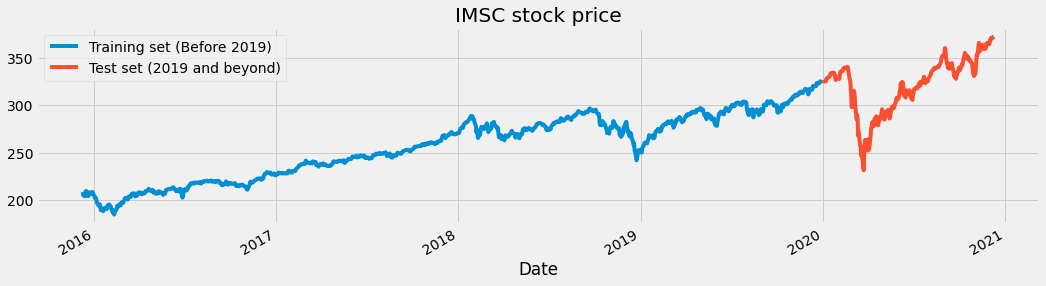

In [ ]:
dataset["High"][:'2019'].plot(figsize=(16,4),legend=True)
dataset["High"]['2020':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019)','Test set (2019 and beyond)'])
plt.title('IMSC stock price')
plt.show()

In [5]:
# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [6]:
def _get_indicator_data(data):
    #Function that uses the finta API to calculate technical indicators used as the features
    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)
    data.head()
    # Also calculate moving averages for features
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
    
    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()
    
    return data

dataset = _get_indicator_data(dataset)


In [ ]:
training_set = dataset[:'2019'].iloc[:,1:2].values
test_set = dataset['2020':].iloc[:,1:2].values

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []
for i in range(60,1020):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))
# Compiling the LSTM
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
30/30 [==============================] - 7s 80ms/step - loss: 0.1080
Epoch 2/50
30/30 [==============================] - 2s 80ms/step - loss: 0.0157
Epoch 3/50
30/30 [==============================] - 2s 80ms/step - loss: 0.0156
Epoch 4/50
30/30 [==============================] - 2s 81ms/step - loss: 0.0187
Epoch 5/50
30/30 [==============================] - 2s 81ms/step - loss: 0.0117
Epoch 6/50
30/30 [==============================] - 3s 85ms/step - loss: 0.0123
Epoch 7/50
30/30 [==============================] - 2s 81ms/step - loss: 0.0094
Epoch 8/50
30/30 [==============================] - 2s 81ms/step - loss: 0.0088
Epoch 9/50
30/30 [==============================] - 2s 83ms/step - loss: 0.0067
Epoch 10/50
30/30 [==============================] - 2s 82ms/step - loss: 0.0065
Epoch 11/50
30/30 [==============================] - 2s 82ms/step - loss: 0.0099
Epoch 12/50
30/30 [==============================] - 2s 80ms/step - loss: 0.0083
Epoch 13/50
30/30 [==================

In [ ]:
dataset_total = pd.concat((dataset["High"][:'2019'],dataset["High"]['2020':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

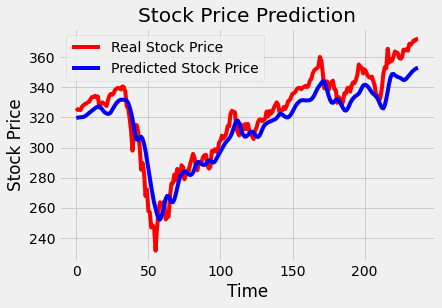

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 0.11147062744379285.


In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
7/7 [==============================] - 7s 189ms/step - loss: 0.2186
Epoch 2/50
7/7 [==============================] - 1s 187ms/step - loss: 0.1220
Epoch 3/50
7/7 [==============================] - 1s 189ms/step - loss: 0.0632
Epoch 4/50
7/7 [==============================] - 1s 209ms/step - loss: 0.0440
Epoch 5/50
7/7 [==============================] - 1s 187ms/step - loss: 0.0443
Epoch 6/50
7/7 [==============================] - 1s 195ms/step - loss: 0.0365
Epoch 7/50
7/7 [==============================] - 1s 190ms/step - loss: 0.0291
Epoch 8/50
7/7 [==============================] - 1s 192ms/step - loss: 0.0236
Epoch 9/50
7/7 [==============================] - 1s 187ms/step - loss: 0.0193
Epoch 10/50
7/7 [==============================] - 1s 189ms/step - loss: 0.0159
Epoch 11/50
7/7 [==============================] - 1s 187ms/step - loss: 0.0118
Epoch 12/50
7/7 [==============================] - 1s 191ms/step - loss: 0.0093
Epoch 13/50
7/7 [==============================] 

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

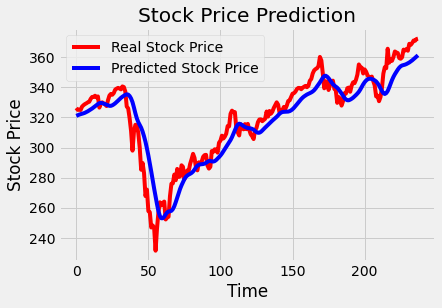

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 0.11161575711290089.


In [ ]:
# The ANN architecture
regressorANN = Sequential()
#First ANN Layer
regressorANN.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu', input_shape=(X_train.shape[1],1)))
#Second ANN Layer
regressorANN.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu'))
#The output layer
regressorANN.add(Dense(units = 1))
#Compiling the ANN
regressorANN.compile(optimizer='adam', loss='mean_squared_error')
#Fitting to the training set
regressorANN.fit(X_train, y_train, epochs=100, batch_size=150)


Epoch 1/100
7/7 [==============================] - 1s 8ms/step - loss: 0.0120
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0034
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 8/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 10/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 11/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 12/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 13/100
7/7 [==============================] - 0s 8ms/

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
ANN_predicted_stock_price = regressorANN.predict(X_test)
ANN_predicted_stock_price = sc.inverse_transform(ANN_predicted_stock_price)

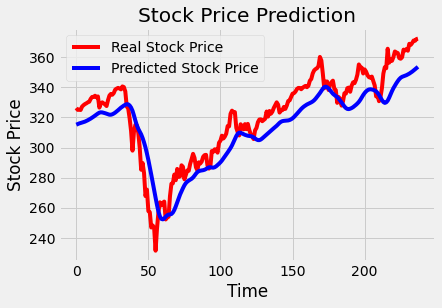

In [ ]:
# Visualizing the results for ANN
plot_predictions(test_set,ANN_predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,ANN_predicted_stock_price)

The root mean squared error is 0.1425581326287013.


In [ ]:
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils import to_categorical
#EMSEMBLE architecture for ANN, LSTM, GRU
members = [regressorANN, regressor, regressorGRU]
# define multi-headed input
ensemble_visible = [model.input for model in members]
# concatenate merge output from each model
ensemble_outputs = [model.output for model in members]
merge = concatenate(ensemble_outputs)
hidden = Dense(10, activation='relu')(merge)
output = Dense(3, activation='softmax')(hidden)
emodel = Model(inputs=ensemble_visible, outputs=output)
# compile
emodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# prepare input data
X = [X_train for _ in range(len(emodel.input))]
# encode output data
inputy_enc = to_categorical(y_train)
# fit model
emodel.fit(X, inputy_enc, epochs=100, batch_size=150)


Epoch 1/100
7/7 [==============================] - 12s 109ms/step - loss: 0.4491 - accuracy: 1.0000
Epoch 2/100
7/7 [==============================] - 1s 109ms/step - loss: 0.4470 - accuracy: 0.9997
Epoch 3/100
7/7 [==============================] - 1s 105ms/step - loss: 0.4456 - accuracy: 0.9836
Epoch 4/100
7/7 [==============================] - 1s 115ms/step - loss: 0.4449 - accuracy: 0.8256
Epoch 5/100
7/7 [==============================] - 1s 111ms/step - loss: 0.4446 - accuracy: 0.6547
Epoch 6/100
7/7 [==============================] - 1s 108ms/step - loss: 0.4445 - accuracy: 0.4025
Epoch 7/100
7/7 [==============================] - 1s 112ms/step - loss: 0.4445 - accuracy: 0.1748
Epoch 8/100
7/7 [==============================] - 1s 104ms/step - loss: 0.4445 - accuracy: 0.1441
Epoch 9/100
7/7 [==============================] - 1s 109ms/step - loss: 0.4445 - accuracy: 0.1561
Epoch 10/100
7/7 [==============================] - 1s 111ms/step - loss: 0.4445 - accuracy: 0.2066
Epoch 11

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X = [X_test for _ in range(len(emodel.input))]
Ensemble_predicted_stock_price = emodel.predict(X)
Ensemble_predicted_stock_price = sc.inverse_transform(Ensemble_predicted_stock_price)

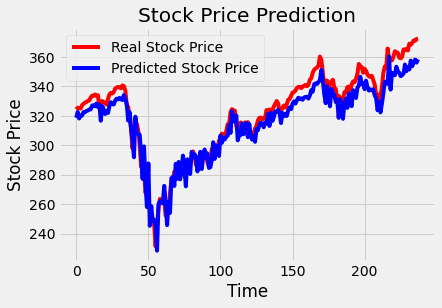

In [ ]:
# Visualizing the results for Ensemble
plot_predictions(test_set,Ensemble_predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,Ensemble_predicted_stock_price)

The root mean squared error is 0.08778239538777712.


ML Models

In [ ]:
#RF architecture
rf = RandomForestRegressor()
params_rf = {'n_estimators': [100,130,140,150,160,180,200]}
gridrf = GridSearchCV(rf, params_rf, cv=10,scoring='neg_mean_squared_error')
gridrf.fit(X_train, y_train)
print(gridrf.best_params_)

{'n_estimators': 140}


In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
RF_predicted_stock_price = gridrf.predict(X_test)
RF_predicted_stock_price = sc.inverse_transform(RF_predicted_stock_price)

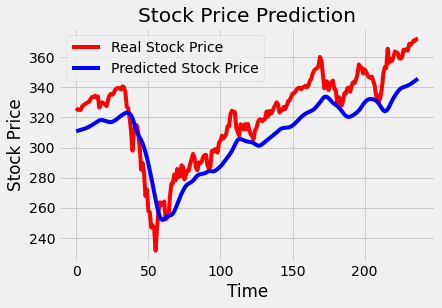

In [ ]:
# Visualizing the results for RF
plot_predictions(test_set,RF_predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,RF_predicted_stock_price)

The root mean squared error is 0.3552744656955655.


In [ ]:
#SVR Architecture
param_grid = {'C': [1, 4, 8, 10, 100, 1000],  
              'gamma': [1, 0.125, 0.1, 0.01], 
              'kernel': ['rbf']}  
  
gridsvr = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3, cv = 10, , scoring='neg_mean_squared_error') 
gridsvr.fit(X_train, y_train)
print(gridsvr.best_params_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.006, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.152, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.351, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.004, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.922, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.013, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.148, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.127, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.083, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........... C=1, gamma=1, kernel=rbf, score=-0.005, total=   0.1s
[CV] C=1, gamma=0.125, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   28.6s finished


In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
SVR_predicted_stock_price = gridsvr.predict(X_test)
SVR_predicted_stock_price = sc.inverse_transform(SVR_predicted_stock_price)

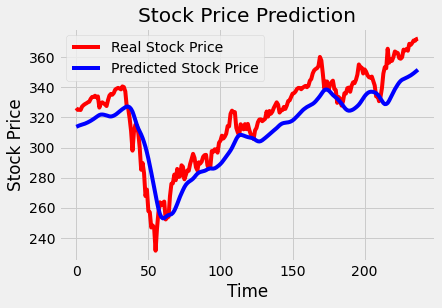

In [ ]:
# Visualizing the results for SVM
plot_predictions(test_set,SVR_predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,SVR_predicted_stock_price)

The root mean squared error is 0.3082731171860835.


In [ ]:
# KNN architecture
knn = KNeighborsRegressor()

parameters = {'n_neighbors':[4,5,6,7, 8, 9],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

#Fit the model
gridknn = GridSearchCV(knn, param_grid=parameters, cv = 10 , scoring='neg_mean_squared_error')
gridknn.fit(X_train, y_train)
print(gridknn.best_params_)


{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 7}


In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
KNN_predicted_stock_price = gridknn.predict(X_test)
KNN_predicted_stock_price = sc.inverse_transform(KNN_predicted_stock_price)

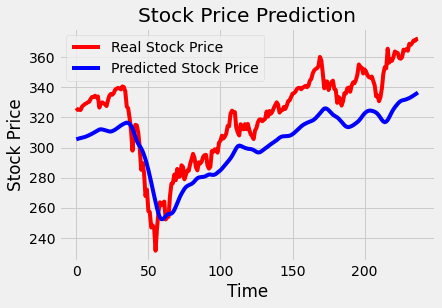

In [ ]:
# Visualizing the results for KNN
plot_predictions(test_set,KNN_predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,KNN_predicted_stock_price)

The root mean squared error is 0.4481916971962379.


In [ ]:
#EMSEMBLE architecture for machine learning models
#Inserting the best params with SVR, RF, KNN
svr = SVR(kernel='rbf', C=1, gamma=1)
svr.fit(X_train, y_train)
rf =  RandomForestRegressor(n_estimators=140)
rf.fit(X_train, y_train)
knn = KNeighborsRegressor(n_neighbors = 7,algorithm = 'auto', leaf_size= 1, n_jobs= -1)
knn.fit(X_train, y_train)
estimators=[('knn', knn), ('rf', rf), ('svm', svr)]
# Create our voting regressor, inputting our models
ensemble = VotingRegressor(estimators)
#fit model to training data
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('knn',
                             KNeighborsRegressor(algorithm='auto', leaf_size=1,
                                                 metric='minkowski',
                                                 metric_params=None, n_jobs=-1,
                                                 n_neighbors=7, p=2,
                                                 weights='uniform')),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
  

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,298):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
Ensemble_predicted_stock_price = ensemble.predict(X_test)
Ensemble_predicted_stock_price = sc.inverse_transform(Ensemble_predicted_stock_price)

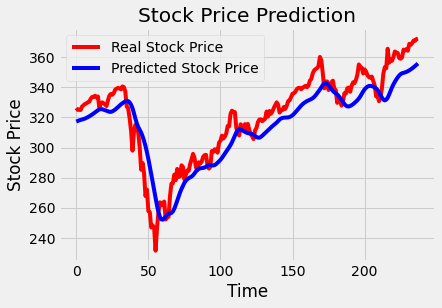

In [ ]:
# Visualizing the results for Ensemble
plot_predictions(test_set,Ensemble_predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,Ensemble_predicted_stock_price)

The root mean squared error is 0.25970275284054084.
